Imports

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.optim as optim

import os
import pickle

import importlib
import src
from src.dataset import info, check
importlib.reload(src)

X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data(one_speed=True, all_features=True)
# check(X_train, "np", (1280004, 6)) # For all speeds
# check(y_train, "np", (1280004, 3))
# check(X_train, "np", (256000, 6)) # For one speed
# check(y_train, "np", (256000, 3))
# check(X_test, "np", (320001, 6))
# check(y_test, "np", (320001, 3))
# check(X_test, "np", (64001, 6))
# check(y_test, "np", (64001, 3))

check(X_train, "np", (256000, 18)) # For one speed, all features
check(y_train, "np", (256000, 3))
check(X_test, "np", (64001, 18))
check(y_test, "np", (64001, 3))

Python random seed set.
NumPy random seed set.
PyTorch random seed set.
Python random seed set.
NumPy random seed set.
PyTorch random seed set.
Loaded from pickle


Model setup

In [2]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)  # RNN layer
        out = self.fc(out[-1, :])  # Last time step for unbatched input
        # out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out, hidden

    def init_hidden(self, batch_size):
        # if batch_size is None:  # Unbatched input
        return torch.zeros(1, self.hidden_size)  # Shape: [num_layers, hidden_size]
        # else:  # Batched input
        #     return torch.zeros(1, batch_size, self.hidden_size)  # Shape: [num_layers, batch_size, hidden_size]

In [3]:
# Model, loss, and optimizer
model = SimpleRNN(18, 16, 1) # input, hidden, output
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [4]:
# Hyperparameters
sequence_length = 5
batch_size = 1024

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

for epoch in range(200):
    model.train()
    total_loss = 0
    hidden = model.init_hidden(batch_size)

    for i in range(0, len(X_train), batch_size):
        x_batch = torch.tensor(X_train[i:i + batch_size])
        y_batch = torch.tensor(y_train[:, 0][i:i + batch_size])

        if x_batch.size(0) != batch_size:  # Skip incomplete batch
            continue

        # Detach hidden state to prevent backprop through its history
        hidden = hidden.detach()

        optimizer.zero_grad()
        output, hidden = model(x_batch, hidden)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"sub-epoch {i}")

    print(f'Epoch {epoch + 1}/200, Loss: {total_loss:.4f}')


/var/folders/_4/qbt6rn_s3_7gh2mhy42959c80000gn/T/ipykernel_16161/3799219310.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(X_train[i:i + batch_size])
/var/folders/_4/qbt6rn_s3_7gh2mhy42959c80000gn/T/ipykernel_16161/3799219310.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_train[:, 0][i:i + batch_size])
/Users/hugojohnson/.virtualenvs/02456-deep-learning-project/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

sub-epoch 0
sub-epoch 1024
sub-epoch 2048
sub-epoch 3072
sub-epoch 4096
sub-epoch 5120
sub-epoch 6144
sub-epoch 7168
sub-epoch 8192
sub-epoch 9216
sub-epoch 10240
sub-epoch 11264
sub-epoch 12288
sub-epoch 13312
sub-epoch 14336
sub-epoch 15360
sub-epoch 16384
sub-epoch 17408
sub-epoch 18432
sub-epoch 19456
sub-epoch 20480
sub-epoch 21504
sub-epoch 22528
sub-epoch 23552
sub-epoch 24576
sub-epoch 25600
sub-epoch 26624
sub-epoch 27648
sub-epoch 28672
sub-epoch 29696
sub-epoch 30720
sub-epoch 31744
sub-epoch 32768
sub-epoch 33792
sub-epoch 34816
sub-epoch 35840
sub-epoch 36864
sub-epoch 37888
sub-epoch 38912
sub-epoch 39936
sub-epoch 40960
sub-epoch 41984
sub-epoch 43008
sub-epoch 44032
sub-epoch 45056
sub-epoch 46080
sub-epoch 47104
sub-epoch 48128
sub-epoch 49152
sub-epoch 50176
sub-epoch 51200
sub-epoch 52224
sub-epoch 53248
sub-epoch 54272
sub-epoch 55296
sub-epoch 56320
sub-epoch 57344
sub-epoch 58368
sub-epoch 59392
sub-epoch 60416
sub-epoch 61440
sub-epoch 62464
sub-epoch 63488
sub-e

KeyboardInterrupt: 

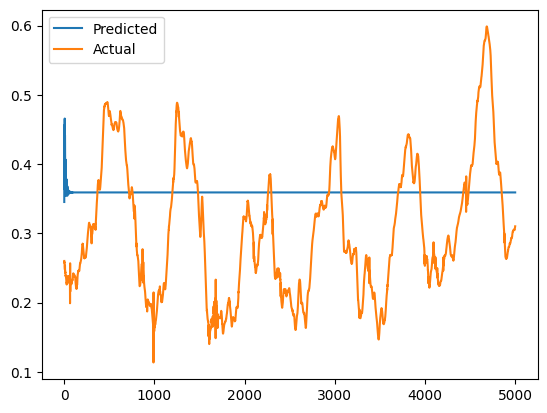

[0.3453580439090729, 0.4562397003173828, 0.4326031804084778, 0.39714837074279785, 0.43952828645706177, 0.4658358097076416, 0.4123501181602478, 0.3628726899623871, 0.4418168067932129, 0.40485596656799316, 0.4036705493927002, 0.37598639726638794, 0.3815561532974243, 0.3941645622253418, 0.3634553551673889, 0.38280239701271057, 0.36819520592689514, 0.40637922286987305, 0.3542328476905823, 0.368746280670166, 0.3785378336906433, 0.3729707896709442, 0.35832032561302185, 0.36533021926879883, 0.3784002661705017, 0.35780882835388184, 0.36594632267951965, 0.3609508275985718, 0.37237533926963806, 0.3619895577430725, 0.35756659507751465, 0.3652476668357849, 0.36424416303634644, 0.36261284351348877, 0.35438692569732666, 0.3678649663925171, 0.36155232787132263, 0.35908418893814087, 0.3586013913154602, 0.36397701501846313, 0.36143696308135986, 0.35683348774909973, 0.3614109456539154, 0.3606310486793518, 0.3615669906139374, 0.3567923307418823, 0.3607540428638458, 0.36144641041755676, 0.3591842651367187

In [8]:
# Test the model
model.eval()
test_input = X_train[:1]
hidden = model.init_hidden(1)
predictions = []

xscale = 5000
for _ in range(xscale):
    output, hidden = model(test_input, hidden)
    predictions.append(output.item())
    # output = output.unsqueeze(1)  # Reshape output to shape (1, 1)
    test_input = torch.cat((test_input[:, 1:], output.unsqueeze(1)), dim=1)

# Plot results
import matplotlib.pyplot as plt

plt.plot(range(xscale), predictions, label="Predicted")
plt.plot(range(xscale), y_test[:, 0][sequence_length:sequence_length + xscale], label="Actual")
plt.legend()
plt.show()

print(predictions)

In [36]:
# y_pred = model.forward(torch.from_numpy(X_test).float())
# info(y_pred)

# # Print the loss
# print("Mean Squared Error:", loss.item())

# start = 10000
# src.plots.evaluate_predictions(y_pred.detach().numpy()[start:start+5000], y_test[:, 0][start:start+5000], loss.item(), name=f"Somethinggg")